In [ ]:
#######################
###### TODO FILL ######
#######################

#@title Author { run: "auto" }
NAME = "" #@param {type: "string"}
EMAIL = "" #@param {type: "string"}

# Convolutional Neural Networks - Home assignment
<b>Author: Martin Kišš, ikiss@fit.vutbr.cz</b>

In this home assignment, your task will be to train a CNN-based image classifier on the CIFAR10 dataset. CIFAR10 is a dataset containing 60k images, where each image
with dimensions `32x32x3` is from one of ten classes. In particular, your task will be to define the architecture of the classifier and the augmentation used during its training.

## How to submit
* Create a **copy** of this notebook. 
* Finish the assigment.
* Export the notebook to `.pdf` (File > Print).
* Send it to ikiss@fit.vutbr.cz (Add the pdf in the attachment).

## Imports
This piece of code only imports some necessary libraries for this home assignment.

In [ ]:
import pickle
import os
from os import path

%matplotlib inline  
import matplotlib.pyplot as plt
from IPython.display import clear_output

import numpy as np

import sys
import torch
from torch import nn

## Creating datasets
Code below downloads (if neccessary) and loads [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). It also defines transformations which are performed when obtaining a batch from the dataset.

### Your task:
*   Define transformations for the training dataset. All available transformations can be found in [PyTorch documentation](https://pytorch.org/vision/stable/transforms.html). Do NOT define transformations for the testing dataset as this data must remain unchanged for fair comparison.

* Recommended transformations: [`ColorJitter`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.ColorJitter), [`RandomAffine`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomAffine), [`RandomHorizontalFlip`](https://pytorch.org/vision/stable/transforms.html#torchvision.transforms.RandomHorizontalFlip)

In [ ]:
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

# Source: https://www.cs.toronto.edu/~kriz/cifar.html
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Define transformations for training and testing dataset
# Look at available transformations at https://pytorch.org/vision/stable/transforms.html
# Training transformation can modify input data in any (sensible) way
training_transformation = transforms.Compose(
    [transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
     transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.0), shear=10, interpolation=transforms.functional.InterpolationMode.BILINEAR),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor()])

# Testing transformation should only normalize the input data - DO NOT CHANGE THIS LINE!
testing_transformation = transforms.Compose([transforms.ToTensor()])

# Create/download dataset
training_dataset = CIFAR10('.', train=True, download=True, transform=training_transformation)
testing_dataset = CIFAR10('.', train=False, download=True, transform=testing_transformation)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


## Visualize data
This code gets a single batch from the training dataset (to visualize the transformations) and displays the images. It also prints sizes of the images and the labels.

Shapes
- data: torch.Size([16, 3, 32, 32])
- labels: torch.Size([16])


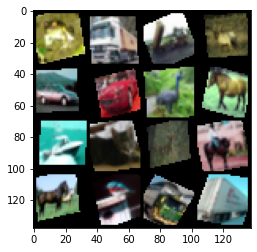

In [ ]:
def show_batch(data):
    # Prepare grid of images and create numpy array from them
    image = torchvision.utils.make_grid(data[:16], nrow=4)
    image = image.numpy().transpose(1, 2, 0)
    plt.grid(False)

    # Display image
    plt.imshow(image)

# Create DataLoader and obtain the first batch of the dataset
loader = torch.utils.data.DataLoader(training_dataset, batch_size=16, shuffle=False, num_workers=1)
batch_data, batch_labels = iter(loader).next()

# Print useful information about the batch and show the data
print("Shapes")
print(f"- data: {batch_data.shape}")
print(f"- labels: {batch_labels.shape}")
show_batch(batch_data)

## Training progress
The two following functions processes statistics obtained during training and outputs them to the screen. The first function plots the training progress into a graph while the second prints the data in format: `Iteration:<iteration> Loss:<training>|<testing> Accuracy:<training>|<testing>`. 

In [ ]:
def draw_progress(data):
  iterations = [item[0] for item in data]
  training_loss = [item[1] for item in data]
  training_accuracy = [item[2] * 100 for item in data]
  testing_loss = [item[3] for item in data]
  testing_accuracy = [item[4] * 100 for item in data]

  plt.plot(iterations, training_loss, label='Training')
  plt.plot(iterations, testing_loss, label='Testing')
  plt.legend()
  plt.ylim([0, None])
  plt.title('Loss')
  plt.show()

  plt.plot(iterations, training_accuracy, label='Training')
  plt.plot(iterations, testing_accuracy, label='Testing')
  plt.legend()
  plt.ylim([0, 100])
  plt.title('Accuracy')
  plt.show()

def print_progress(data):
  for (iteration, training_loss, training_accuracy, testing_loss, testing_accuracy) in data:
    print(f"Iteration:{iteration} Loss:{training_loss:.3f}|{testing_loss:.3f} Accuracy:{100*training_accuracy:.2f}%|{100*testing_accuracy:.2f}%")

## Testing the model
The following function tests the model on a given dataset. For each sample in the dataset, it calculates output, its loss, and correctness. In the end it computes average loss value and accuracy of the model.

In [ ]:
def test(model, data_loader):
	model = model.eval()
	
  # Accumulators
	loss_acc = 0
	accuracy_acc = 0
	counter = 0
	
  # Loop through dataset
	for batch_data, batch_labels in data_loader:
    # Calculate output
		logits = model(batch_data)
  
    # Accumulate loss value
		loss_acc += criterion(logits, batch_labels).item()

		# Compute and accumulate ratio of correct label predictions
		max_scores, pred_labels = torch.max(logits, dim=1)
		accuracy_acc += torch.sum(pred_labels == batch_labels).item() / batch_data.shape[0]
		counter += 1
 
	model = model.train()
	return loss_acc / counter, accuracy_acc / counter

## Training step

This function updates the model on a single batch. First, given the input image, it calculates the output of the model. Then, loss value is calculated using the criterion (loss function). Next, gradiants are calculated and optimizer updates the model. Finally, the loss value and the output are returned.

In [ ]:
def training_step(model, input_data, target_labels, criterion, optimizer):
	# Forward pass - compute network autput and store all activations
	outputs = model(input_data)
	
	# Compute loss
	loss = criterion(outputs, target_labels)
   
	# Backward pass - compute gradients
	optimizer.zero_grad()
	loss.backward()

	# Optimize network
	optimizer.step()

 	# .item() and .detach() disconects from comp. graph
	return loss.item(), outputs.detach()

## Defining the network
This function below defines the CNN, the code after creates new instance of the network and prints the architecture.

### Your task:


*   Define the network as a [sequential model](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html). All available layers can be found in [PyTorch documentation](https://pytorch.org/docs/stable/nn.html).
*   Your network might look something like this:
  *   Input shape: `(N, 3, 32, 32) // (BatchSize, NumberOfChannels/Features, Height, Width)`
  *   **`2x Conv2d`** layer, **`3x3`** kernel, **`32`** output features, **`padding='same'`**, **`ReLU`** non-linear function **`after each`** convolutional layer
  *   **`MaxPooling`** layer, **`2x2`** kernel\
      *Shape: `(N, 32, 16, 16)`*
  *   **`2x Conv2d`** layer, **`3x3`** kernel, **`64`** output features, **`padding='same'`**, **`ReLU`** non-linear function **`after each`** convolutional layer
  *   **`MaxPooling`** layer, **`2x2`** kernel\
      *Shape: `(N, 64, 8, 8)`*
  *   **`2x Conv2d`** layer, **`3x3`** kernel, **`128`** output features, **`padding='same'`**, **`ReLU`** non-linear function **`after each`** convolutional layer
  *   **`MaxPooling`** layer, **`2x2`** kernel\
      *Shape: `(N, 128, 4, 4)`*
  *   **`Flatten`** layer\
      *Shape: `(N, 128 * 4 * 4)`*
  *   **`Linear`** layer, **`128`** output features, **`ReLU`** non-linear function
  *   **`Dropout`** layer, **`p=0.1`**\
      *Shape: `(N, 128)`*
  *   **`Linear layer`**, **`10`** output features
  *   Output shape: `(N, 10)`
*   You can also be inspired, for example, by the [VGG16 network](https://neurohive.io/en/popular-networks/vgg16/) but remember that the input is an image with dimensions **`32x32x3`** and the output must be a **`10`**-dimensional vector.


      
</ul>

In [ ]:
def create_network():
	network = nn.Sequential(
			#
			# Input: (N, 3, 32, 32)
			#
			nn.Conv2d(3, 32, (3,3), padding='same'),
			nn.ReLU(),
      nn.Conv2d(32, 32, (3,3), padding='same'),
			nn.ReLU(),
			nn.MaxPool2d((2,2)),
			#
			# (N, 32, 16, 16)
			#
			nn.Conv2d(32, 64, (3,3), padding='same'),
			nn.ReLU(),
			nn.Conv2d(64, 64, (3,3), padding='same'),
			nn.ReLU(),
			nn.MaxPool2d((2,2)),
			#
			# (N, 64, 8, 8)
			#
			nn.Conv2d(64, 128, (3,3), padding='same'),
			nn.ReLU(),
			nn.Conv2d(128, 128, (3,3), padding='same'),
			nn.ReLU(),
			nn.MaxPool2d((2,2)),
			#
			# (N, 128, 4, 4)
			#
			nn.Flatten(),
			#
			# (N, 2048)
			#
			nn.Linear(2048, 128),
			nn.ReLU(),
			nn.Dropout(0.1),
			#
			# (N, 128)
			#
			nn.Linear(128, 10)
      #
      # (N, 10)
      #
        )

	return network

# Create new model and print its structure
model = create_network()
print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (6): ReLU()
  (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (11): ReLU()
  (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (15): Flatten(start_dim=1, end_dim=-1)
  (16): Linear(in_features=2048, out_features=128, bias=True)
  (17): ReLU()
  (18): Dropout(p=0.1, inplace=False)
  (19): Linear(in_features=128, out_fea

## Training setup

This piece of code defines the training process. It initializes the batch size, view step, number of the training iterations, data loaders, criterion (loss function), and optimizer.

In [ ]:
# Training setup
batch_size = 64
view_step = 1000
iterations = 25000

# Create training and testing DataLoaders
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
testing_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=4, shuffle=True, pin_memory=True, num_workers=2)  

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training the model

This code loops through the training dataset (data loader) and performs training step. At given iterations (view steps) the model is tested and information about the progress is visualized in graphs and printed to the output window.

In [ ]:
# Accumulators
loss_acc = 0
accuracy_acc = 0

training_progress = []

iteration = 0
stop_training = False

# When we reach the end of the dataset, but do not want to end the training, we loop through it again
while not stop_training:
  # Obtain batch from the training dataset in a loop
  for batch_data, batch_labels in training_loader:
    iteration += 1

    # Do a training step
    loss, outputs = training_step(model, batch_data, batch_labels, criterion, optimizer)
    
    # Accumulate loss for statistics
    loss_acc += loss

    # Compute and accumulate ratio of correct label predictions for statistics
    max_scores, pred_labels = torch.max(outputs, 1)
    accuracy_acc += torch.sum(pred_labels == batch_labels).item() / float(batch_size) 

    # Test model 
    if iteration % view_step == 0:
      # Calculate loss and accuracy on the testing dataset
      test_loss_acc, test_accuracy_acc = test(model, testing_loader)      
      training_progress.append((iteration, loss_acc / view_step, accuracy_acc / view_step, test_loss_acc, test_accuracy_acc))

      # Clear output window and show training progress
      clear_output()
      draw_progress(training_progress)
      print_progress(training_progress)
      
      # Reset the accumulators
      loss_acc = 0
      accuracy_acc = 0 

    # Stop training when amount of iterations is reached
    if iteration >= iterations:
      stop_training = True
      break

print("Training finished.")

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Using the model

The code below uses the model to predict labels of images from the testing dataset.

[ 0.11, 0.09, 0.09, 0.11, 0.11, 0.10, 0.10, 0.10, 0.09, 0.11 ] ... 3 (cat) [10.86%]
[ 0.11, 0.09, 0.09, 0.11, 0.11, 0.10, 0.10, 0.10, 0.09, 0.11 ] ... 3 (cat) [10.86%]
[ 0.11, 0.09, 0.09, 0.11, 0.11, 0.10, 0.10, 0.10, 0.09, 0.11 ] ... 3 (cat) [10.86%]
[ 0.11, 0.09, 0.09, 0.11, 0.11, 0.10, 0.10, 0.10, 0.09, 0.11 ] ... 3 (cat) [10.86%]


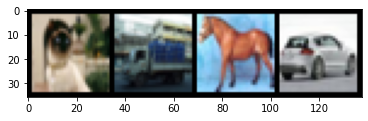

In [ ]:
def print_output(data):
  # Calculate probabilities from logits
  data = nn.functional.softmax(data, dim=1)
  # Calculate maxima and labels
  max_scores, pred_labels = torch.max(data, dim=1)
  
  # Print output line by line
  for (label, score, probs) in zip(pred_labels, max_scores, data):
    probs = f"[ {', '.join([f'{prob:.2f}' for prob in probs])} ]"
    print(f"{probs} ... {label} ({classes[label]}) [{score * 100:.2f}%]")


model = model.eval()

# Get data from tesing dataset
batch_data, batch_labels = iter(testing_loader).next()
# Show data
show_batch(batch_data)
# Run model and print output
print_output(model(batch_data).detach())

model = model.train()